In [ ]:
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import yaml

credentials = yaml.load(open('../.secrets.yml'), Loader=yaml.FullLoader)

"""
Set configuration here
"""
CONTRACT_ADDRESS = '0x9A534628B4062E123cE7Ee2222ec20B86e16Ca8F'
COLLECTION = 'MekaVerse'
METHOD = 'raritytools'
TOKEN_COL = 'TOKEN_ID'  # Use TOKEN_NAME if you prefer to infer token id from token name
NUMBERS_TO_CHECK = 50  # Number of tokens to search for opportunities
OPENSEA_API_KEY = credentials["personal"]["opensea_api_key"]


# Define variables used throughout
RARITY_DATABASE = f'../metadata/rarity_data/{COLLECTION}_{METHOD}.csv'
ETHER_UNITS = 1E18

# Load rarity database and format
RARITY_DB = pd.read_csv(RARITY_DATABASE)
RARITY_DB = RARITY_DB[RARITY_DB['TOKEN_ID'].duplicated()==False]
if TOKEN_COL == 'TOKEN_NAME':
    RARITY_DB['TOKEN_ID'] = RARITY_DB['TOKEN_NAME'].str.split('#').str[1].astype(int)

           ranks       bid
token_ids                 
1922         1.0   0.70000
1922         1.0   0.72000
1922         1.0   0.72000
1922         1.0  15.00000
1922         1.0  20.00000
1922         1.0   0.80190
6273         2.0   0.72000
6273         2.0   0.76690
6273         2.0   0.00001
6273         2.0  15.00000
6242         3.0  15.00000
6242         3.0  18.00000
2370         4.0   0.78300
2370         4.0   0.80000
2370         4.0   0.72000
2370         4.0   2.00000
7796         5.0   0.80000
7796         5.0   0.78300
7796         5.0   0.72000
7796         5.0   4.00000
7796         5.0   0.71690
8075         6.0   0.56030
8075         6.0   0.80700
8075         6.0   0.80000
8075         6.0   0.71690
1784         7.0   0.84700
1784         7.0   0.75690
2423         8.0   0.72000
2423         8.0   0.73190
4370         9.0   3.00000
4370         9.0   0.84700
4370         9.0   0.72000
4370         9.0   0.77190
3139        10.0   0.71820
3139        10.0   0.71820
3

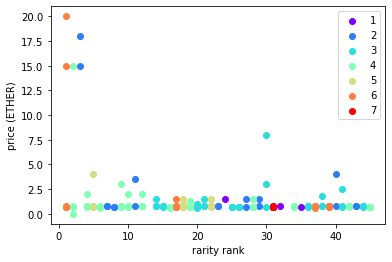

In [ ]:
"""
Get open bids from OpenSea and plot.
"""


def getOpenseaOrders(token_id, contract_address):
    url = "https://api.opensea.io/wyvern/v1/orders"    

    querystring = {
        "bundled": "false",
        "include_bundled": "false",
        "is_english": "false",
        "include_invalid": "false",
        "limit": "50",
        "offset": "0",
        "order_by": "created_date",
        "order_direction": "desc",
        "asset_contract_address": contract_address, 
        "token_ids": [token_id]}

    headers = {
        "Accept" : "application/json", 
        "X-API-KEY" : OPENSEA_API_KEY
    }
    
    response = requests.request("GET", url, headers=headers, params=querystring)
    response_json = response.json()
    return response_json


def plot_all_bids(bid_db):
    series = []
    max_listings = (bid_db['token_ids'].value_counts().max())
    
    for i in range(1, max_listings+1):
        n_bids = bid_db.groupby("token_ids").filter(lambda x: len(x)==i)
        series.append(n_bids)
    
    colors = iter(cm.rainbow(np.linspace(0, 1, len(series))))
    for i in range(0,len(series)):
        plt.scatter(series[i]["ranks"], series[i]["bid"], color=next(colors), label=i+1)
        plt.xlabel("rarity rank")
        plt.ylabel("price (ETHER)")
        plt.legend(loc='best')

    plt.show() 
    

def get_all_bids(rarity_db):
    token_ids = []
    ranks = []
    bids = []
    numbersToCheck=[]
    
    for x in rarity_db['TOKEN_ID']:
        numbersToCheck.append(x)
        
        if len(numbersToCheck) == 15: # send 15 NFTs at a time to API
            orders = getOpenseaOrders(numbersToCheck, CONTRACT_ADDRESS)
            numbersToCheck = []    

            for order in orders['orders']:
                if order["side"] == 0:
                    tokenId = int(order['asset']['token_id'])
                    token_ids.append(tokenId)
                    ranks.append(float(rarity_db[rarity_db['TOKEN_ID']==tokenId]['Rank']))
                    bids.append(float(order['base_price']) / ETHER_UNITS)

    bid_db = pd.DataFrame(columns = ["token_ids", "ranks", "bid"])
    bid_db["token_ids"] = token_ids
    bid_db["ranks"] = ranks
    bid_db["bid"] = bids
    return bid_db

bid_db = get_all_bids(RARITY_DB.head(NUMBERS_TO_CHECK))   
bid_db = bid_db.sort_values(by=['ranks'])

print(bid_db.set_index('token_ids').head(50)) 
plot_all_bids(bid_db)

In [ ]:
"""
Get open offers from OpenSea and plot.
"""


def getOpenseaOrders(token_id, contract_address):
    # gets orders, both bids and asks
    # divide token_list into limit sized chunks and get output
    url = "https://api.opensea.io/wyvern/v1/orders"    
    querystring = {
        "bundled":"false",
        "include_bundled":"false",
        "is_english":"false",
        "include_invalid":"false",
        "limit":"50",
        "offset":"0",
        "order_by":"created_date",
        "order_direction":"desc", 
        "asset_contract_address":contract_address,
        "token_ids":[token_id]
    }
    
    headers = {
        "Accept" : "application/json", 
        "X-API-KEY" : OPENSEA_API_KEY
        }

    response = requests.request("GET", url, headers=headers, params=querystring)
    responseJson=response.json()
    return responseJson

def display_orders(rarity_db):
    print('RANK TOKEN_ID PRICE URL')
    numbersToCheck = []
    for x in rarity_db['TOKEN_ID']:
        numbersToCheck.append(x)
        if len(numbersToCheck) == 15:
            orders = getOpenseaOrders(numbersToCheck, CONTRACT_ADDRESS)
            numbersToCheck = []
            time.sleep(2)
            for order in orders['orders']:
                if order['side'] == 1:
                    tokenId = int(order['asset']['token_id'])
                    price = float(order['current_price']) / 1E18
                    if price <= 20:
                        current_order = dict()
                        current_order['RANK'] = str(int(rarity_db[rarity_db['TOKEN_ID']==tokenId]['Rank']))
                        current_order['TOKEN_ID'] = str(tokenId)
                        current_order['PRICE'] = str(price)
                        current_order['URL'] = f'https://opensea.io/assets/{CONTRACT_ADDRESS}/{tokenId}'
                        str_to_print = ''
                        for x in ['RANK', 'TOKEN_ID', 'PRICE']:
                            str_to_print += f'{current_order[x]}'
                            str_to_print += ' ' * (len(x) + 1 - len(current_order[x]))
                        str_to_print += current_order['URL']
                        print(str_to_print)

display_orders(RARITY_DB.head(NUMBERS_TO_CHECK))

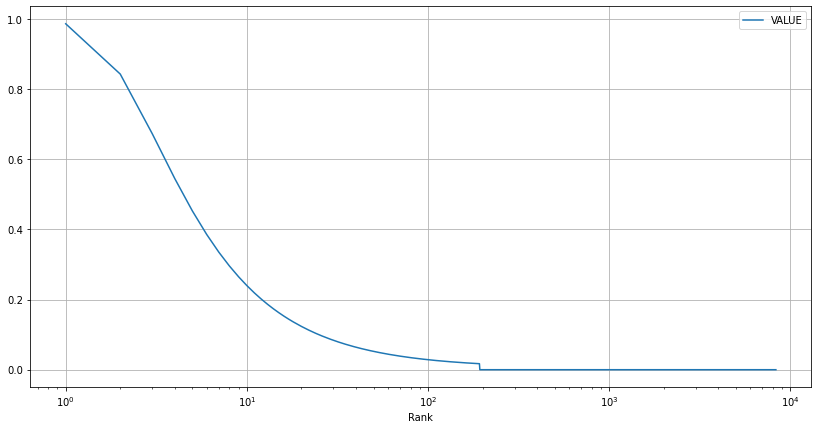

In [ ]:
import numpy as np
A = -0.9
K = 1
B = 5
v = 1
Q = 1.1
C = 1

RARITY_DB['VALUE'] = A + ((K - A) / np.power((C + Q * np.exp(-B * (1 / RARITY_DB['Rank']))), 1 / v))
RARITY_DB['VALUE'] = np.where(RARITY_DB['Rank']>96*2, 0, RARITY_DB['VALUE'])
RARITY_DB[['Rank', 'VALUE']].sort_values('Rank').plot(x='Rank', y='VALUE', figsize=(14, 7), logx=True, grid=True)
plt.show()

<AxesSubplot:xlabel='TOKEN_ID'>

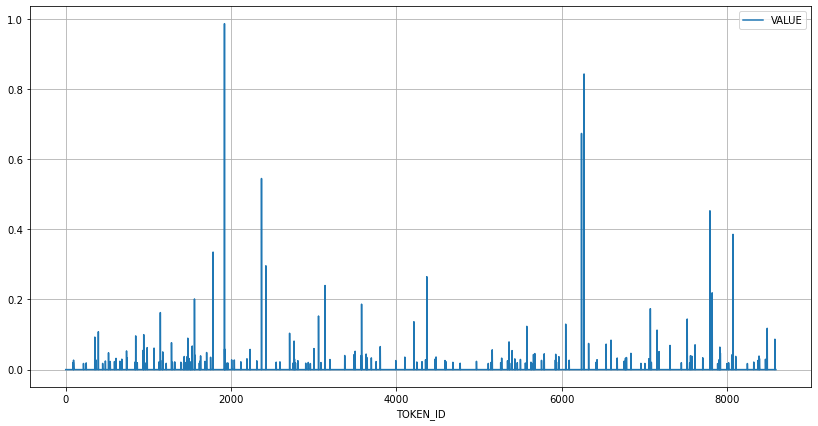

In [ ]:
RARITY_DB = RARITY_DB.sort_values('TOKEN_ID')
RARITY_DB.plot(x='TOKEN_ID', y='VALUE', grid=True, figsize=(14, 7))

<AxesSubplot:xlabel='TOKEN_ID'>

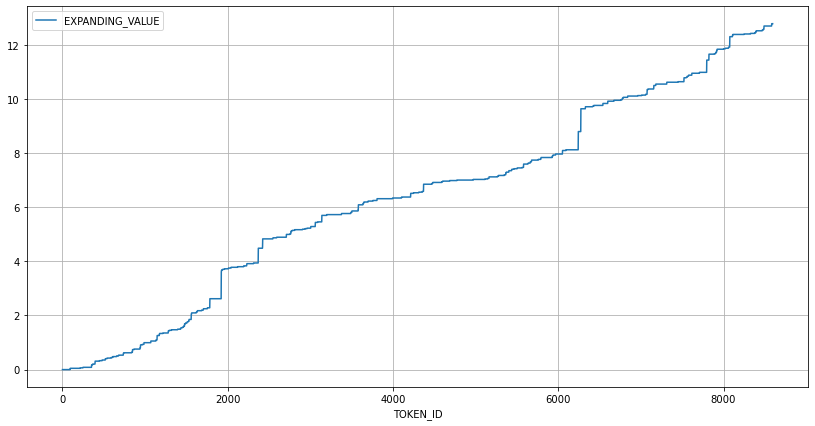

In [ ]:
RARITY_DB = RARITY_DB.sort_values('TOKEN_ID')
RARITY_DB['EXPANDING_VALUE'] = RARITY_DB['VALUE'].expanding().sum()
RARITY_DB.plot(x='TOKEN_ID', y='EXPANDING_VALUE', grid=True, figsize=(14, 7))

In [ ]:
pd.set_option('display.max_rows', 100)
RARITY_DB.sort_values('Rank').head(96)